In [1]:
import whynot as wn
import numpy as np
from sklearn.svm import SVC
from whynot import repeated_classification
import matplotlib.pyplot as plt
%matplotlib inline

Visualize generated distribution, intended to look like graph on [page 3](https://arxiv.org/pdf/1806.08010.pdf)

init:
State(expected_populations=array([1000, 1000]), populations=array([1000, 1000]), features=array([[-1.0692108 , -0.69905647],
       [-0.92145739, -0.00878733],
       [-1.07558466,  0.20669988],
       ...,
       [ 0.77041205,  0.7076799 ],
       [ 0.7444506 , -0.77249392],
       [ 1.06815913,  0.76290768]]), labels=array([0, 0, 1, ..., 1, 0, 1]), classifier_params=array([0.01438396, 3.6939874 , 0.0681274 ]), risks=array([0.204, 0.191]))


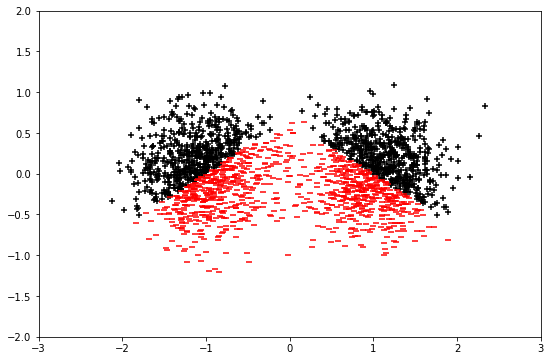

In [2]:
def graph(features, labels, params=None):
    plt.figure(figsize=(9, 6))

    plt.scatter(*features[labels.astype(bool)].T, marker='+', color='k')
    plt.scatter(*features[(1 - labels).astype(bool)].T, marker='_', color='r')
    
    xlims = np.array([-3, 3])
    if params is not None:
        plt.plot(xlims, -params[0] / params[1] * xlims - params[2] / params[1], color='b')

    plt.xlim(xlims)
    plt.ylim((-2, 2))

    plt.show()


init = repeated_classification.experiments.sample_initial_states(np.random.RandomState())
print('init:\n' + str(init))

graph(init.features, init.labels)

Run to see progress at each step

In [ ]:
experiments = repeated_classification.get_experiments()
experiments[0].run(1, parallelize=False)

Using `scipy.optimize.minimize` generally fits slightly better than using linear SVM

In [4]:
config = repeated_classification.experiments.construct_config()
rng = np.random.RandomState()

POPULATIONS = [3000, 3000]  # modify

features, labels = [], []
for pop, dist in list(zip(POPULATIONS, config.group_distributions)):
    features_k, labels_k = dist(pop, rng)
    features.append(features_k)
    labels.append(labels_k)
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# SVM
c_values = [0.01, 0.1, 1, 10]
models = [SVC(C=c, kernel='linear').fit(features, labels) for c in c_values]
params = [np.concatenate([m.coef_.flatten(), m.intercept_.flatten()]) for m in models]
accuracies = [
    np.count_nonzero(labels == repeated_classification.experiments.linear_classifier_2d(features, p, None))
    for p in params
]
for (c, acc) in zip(c_values, accuracies):
    print('linear SVM with C = {: >6.2f} :  {:>6d} / {} correct'.format(c, acc, len(labels)))

# ERM with scipy.optimize.minimize
erm_params = repeated_classification.experiments.empirical_risk_minimization(
    repeated_classification.experiments.linear_classifier_2d,
    repeated_classification.experiments.zero_one_loss,
    features,
    labels,
    [0, 1, 0],
    rng,
    method='Powell'
)
erm_acc = np.count_nonzero(
    labels == repeated_classification.experiments.linear_classifier_2d(features, erm_params, None)
)
print('scipy.optimize.minimize    :  {: >6d} / {} correct'.format(erm_acc, len(labels)))

linear SVM with C =   0.01 :    4906 / 6000 correct
linear SVM with C =   0.10 :    4906 / 6000 correct
linear SVM with C =   1.00 :    4908 / 6000 correct
linear SVM with C =  10.00 :    4908 / 6000 correct
scipy.optimize.minimize    :    4910 / 6000 correct
